In this notebook we will see how to embed a batch of sequences using ESM C, as well as explore its different layers

# Set up Forge client for ESM C

Grab a token from [the Forge console](https://forge.evolutionaryscale.ai/console) and add it below. Note that your token is like a password for your account and you should take care to protect it. For this reason it is recommended to frequently create a new token and delete old, unused ones. It is also recommended to paste the token directly into an environment variable or use a utility like `getpass` as shown below so tokens are not accidentally shared or checked into code repositories.

In [1]:
# Install esm and other dependencies
! pip install esm
! pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.

In [6]:
from getpass import getpass

token = getpass("Token from Forge console: ")

Token from Forge console: ··········


In [7]:
from esm.sdk import client

model = client(
    model="esmc-300m-2024-12", url="https://forge.evolutionaryscale.ai", token=token
)

# Set up utilities for embedding sequences

Since we're embedding more than a few sequences, we're going to use a threaded async call to Forge and let Forge take care of batching and parallelization on the backend.

In [8]:
from concurrent.futures import ThreadPoolExecutor
from typing import Sequence

from esm.sdk.api import (
    ESM3InferenceClient,
    ESMProtein,
    ESMProteinError,
    LogitsConfig,
    LogitsOutput,
    ProteinType,
)

EMBEDDING_CONFIG = LogitsConfig(
    sequence=True, return_embeddings=True, return_hidden_states=True
)


def embed_sequence(model: ESM3InferenceClient, sequence: str) -> LogitsOutput:
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.encode(protein)
    print(protein_tensor)
    output = model.logits(protein_tensor, EMBEDDING_CONFIG)
    return output


def batch_embed(
    model: ESM3InferenceClient, inputs: Sequence[ProteinType]
) -> Sequence[LogitsOutput]:
    """Forge supports auto-batching. So batch_embed() is as simple as running a collection
    of embed calls in parallel using asyncio.
    """
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(embed_sequence, model, protein) for protein in inputs
        ]
        results = []
        for future in futures:
            try:
                results.append(future.result())
            except Exception as e:
                results.append(ESMProteinError(500, str(e)))
    return results

# Requesting a specific hidden layer

ESM C 6B's hidden states are really large, so we only allow one specific layer to be requested per API call. This also works for other ESM C models, but it is required for ESM C 6B.
Refer to https://forge.evolutionaryscale.ai/console to find the number of hidden layers for each model.

In [ ]:
# ESMC_6B_EMBEDDING_CONFIG = LogitsConfig(return_hidden_states=True, ith_hidden_layer=55)

# Load dataset

This dataset is taken from Muir, et al. 2024 ["Evolutionary-Scale Enzymology Enables Biochemical Constant Prediction Across a Multi-Peaked Catalytic Landscape"](https://doi.org/10.1101/2024.10.23.619915) which explores a model enzyme called Adenylate Kinase (ADK). Adenylate Kinase appears in many different organisms with different structural classes (referred to as its "lid type"). We'll embed this set of ADK sequences and see if we can recover known structural classes.

In [5]:
# !wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1SpOkL11MJxIgy99dqufvUNJuCiuhxuyg" -O adk.csv

--2025-03-03 07:50:02--  https://docs.google.com/uc?export=download&id=1SpOkL11MJxIgy99dqufvUNJuCiuhxuyg
Resolving docs.google.com (docs.google.com)... 142.251.2.101, 142.251.2.113, 142.251.2.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1SpOkL11MJxIgy99dqufvUNJuCiuhxuyg&export=download [following]
--2025-03-03 07:50:02--  https://drive.usercontent.google.com/download?id=1SpOkL11MJxIgy99dqufvUNJuCiuhxuyg&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.137.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43132 (42K) [application/octet-stream]
Saving to: ‘adk.csv’

adk.csv             100%[===================>]  42.12K  --.-KB/s    in 0.006s  

20

In [16]:
import pandas as pd
adk_path = "/content/HOM_MouseHumans_sequence.csv"
df = pd.read_csv(adk_path, nrows=10)
df = df[["sequence_h", "sequence_m"]][:3]


In [6]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns

# adk_path = "adk.csv"
# df = pd.read_csv(adk_path)
# df = df[["org_name", "sequence", "lid_type", "temperature"]]
# df = df[df["lid_type"] != "other"]  # drop one structural class for simplicity

In [17]:
# You may see some error messages due to rate limits on each Forge account,
# but this will retry until the embedding job is complete
# This may take a few minutes to run
outputs_h = batch_embed(model, df["sequence_h"].tolist())
outputs_m = batch_embed(model, df["sequence_m"].tolist())

ESMProteinTensor(sequence=tensor([ 0, 20, 11, 11,  8, 16, 15, 21, 10, 13, 18,  7,  5,  9, 14, 20,  6,  9,
        15, 14,  7,  6,  8,  4,  5,  6, 12,  6,  9,  7,  4,  6, 15, 15,  4,  9,
         9, 10,  6, 18, 13, 15,  5, 19,  7,  7,  4,  6, 16, 18,  4,  7,  4, 15,
        15, 13,  9, 13,  4, 18, 10,  9, 22,  4, 15, 13, 11, 23,  6,  5, 17,  5,
        15, 16,  8, 10, 13, 23, 18,  6, 23,  4, 10,  9, 22, 23, 13,  5, 18,  4,
         2]), structure=None, secondary_structure=None, sasa=None, function=None, residue_annotations=None, coordinates=None, potential_sequence_of_concern=False)
ESMProteinTensor(sequence=tensor([ 0, 20,  6,  8,  6,  8,  8,  8, 19, 10, 14, 15,  5, 12, 19,  4, 13, 12,
        13,  6, 10, 12, 16, 15,  7, 12, 18,  8, 15, 19, 23, 17,  8,  8, 13, 12,
        20, 13,  4, 18, 23, 12,  5, 11,  6,  4, 14, 10, 17, 11, 11, 12,  8,  4,
         4, 11, 11, 13, 13,  5, 20,  7,  8, 12, 13, 14, 11, 20, 14,  5, 17,  8,
         9, 10, 11, 14, 19, 15,  7, 10, 14,  7,  5, 12, 15, 16,  

In [13]:
outputs_h

[LogitsOutput(logits=ForwardTrackData(sequence=tensor([[-35.2500, -35.2500, -35.2500,  ..., -35.2500, -35.2500, -35.2500],
         [-38.0000, -38.0000, -38.0000,  ..., -38.0000, -38.0000, -38.0000],
         [-30.6250, -30.6250, -30.5000,  ..., -30.5000, -30.5000, -30.5000],
         ...,
         [-21.6250, -21.5000, -21.5000,  ..., -21.5000, -21.6250, -21.6250],
         [-28.3750, -28.3750, -28.3750,  ..., -28.3750, -28.5000, -28.3750],
         [-32.7500, -32.7500, -32.7500,  ..., -32.7500, -32.7500, -32.7500]]), structure=None, secondary_structure=None, sasa=None, function=None), embeddings=tensor([[[ 0.0014,  0.0081,  0.0066,  ...,  0.0061, -0.0117, -0.0173],
          [-0.0017,  0.0185, -0.0162,  ..., -0.0232, -0.0509, -0.0215],
          [-0.0291,  0.0337, -0.0151,  ..., -0.0305, -0.0626, -0.0497],
          ...,
          [-0.0213, -0.0045, -0.0337,  ..., -0.0349, -0.0101,  0.0056],
          [-0.0072, -0.0406, -0.0065,  ...,  0.0179, -0.0546,  0.0008],
          [ 0.0225,  0

In [20]:
import torch

# we'll summarize the embeddings using their mean across the sequence dimension
# which allows us to compare embeddings for sequences of different lengths
all_mean_embeddings_h = [
    torch.mean(output.hidden_states, dim=-2).squeeze() for output in outputs_h
]
all_mean_embeddings_m = [
    torch.mean(output.hidden_states, dim=-2).squeeze() for output in outputs_m
]


embedding shape [num_layers, hidden_size]: torch.Size([31, 960])


In [31]:

# now we have a list of tensors of [num_layers, hidden_size]
print("embedding shape [num_layers, hidden_size]:", all_mean_embeddings_h[0].shape)

embedding shape [num_layers, hidden_size]: torch.Size([31, 960])


# Examine the performance of different layer embeddings

For this example, we're going to use PCA to visualize whether the embeddings separate our proteins by their structural class. To assess the quality of our PCA, we fit a K means classifier with three clusters, corresponding to the three structural classes of our enzyme, and compute the [rand index](https://en.wikipedia.org/wiki/Rand_index), a measure of the quality of the clustering.

In [22]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
N_KMEANS_CLUSTERS = 3

In [27]:


def plot_embeddings_at_layer(all_mean_embeddings_h, all_mean_embeddings_m, layer_idx: int, df: pd.DataFrame):
    # 将 `sequence_h` 和 `sequence_m` 嵌入向量合并
    embeddings_h = torch.stack([embedding[layer_idx, :] for embedding in all_mean_embeddings_h]).numpy()
    embeddings_m = torch.stack([embedding[layer_idx, :] for embedding in all_mean_embeddings_m]).numpy()

    # 合并两个嵌入
    stacked_mean_embeddings = np.vstack([embeddings_h, embeddings_m])

    # 使用 PCA 降维到 2D
    pca = PCA(n_components=2)
    projected_mean_embeddings = pca.fit_transform(stacked_mean_embeddings)

    # KMeans 聚类
    kmeans = KMeans(n_clusters=2, random_state=0).fit(projected_mean_embeddings)
    kmeans_labels = kmeans.labels_

    # 计算 Adjusted Rand Index (ARI) 评估聚类效果
    rand_index = adjusted_rand_score([0] * len(embeddings_h) + [1] * len(embeddings_m), kmeans_labels)

    # 标签：0 表示 `sequence_h`，1 表示 `sequence_m`
    labels = [0] * len(embeddings_h) + [1] * len(embeddings_m)

    # 绘制 PCA + KMeans 聚类结果
    plt.figure(figsize=(6, 6))
    sns.scatterplot(
        x=projected_mean_embeddings[:, 0],
        y=projected_mean_embeddings[:, 1],
        hue=kmeans_labels,  # 用颜色表示 KMeans 结果
        palette="viridis",
        style=labels,  # 用形状区分 sequence_h (o) 和 sequence_m (s)
        markers=["o", "s"],
    )

    # 标题
    plt.title(f"PCA of Mean Embeddings at Layer {layer_idx} (Rand Index: {rand_index:.2f})")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend(title="Cluster", loc="best")
    plt.show()


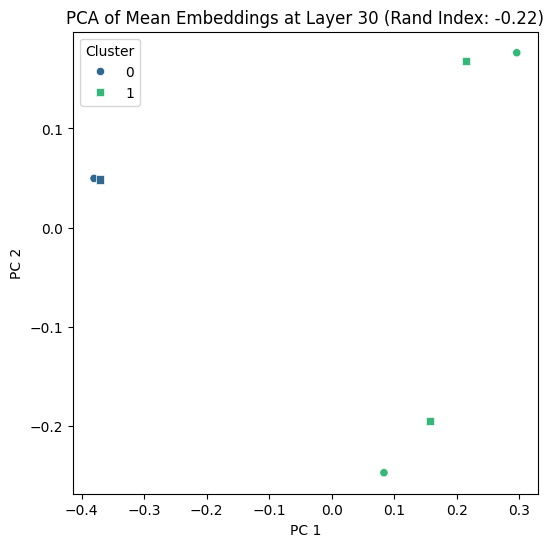

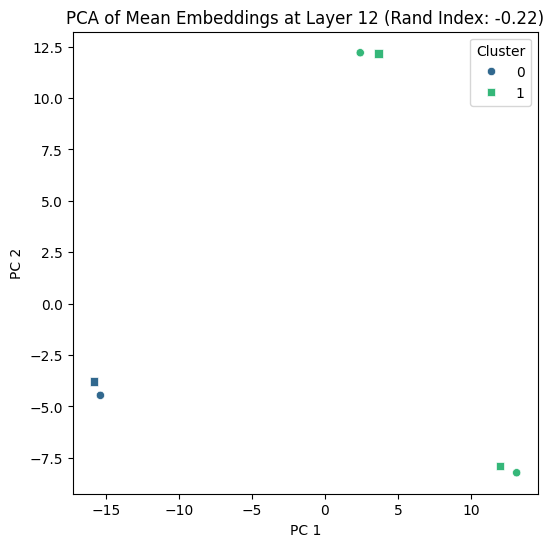

In [28]:
plot_embeddings_at_layer(all_mean_embeddings_h, all_mean_embeddings_m, layer_idx=30, df=df)
plot_embeddings_at_layer(all_mean_embeddings_h, all_mean_embeddings_m, layer_idx=12, df=df)

We see that the top principal components of layer 12 separate structural classes better than that of layer 30. Embed away! And keep in mind that different layers may be better or worse for your particular use-case.